<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

Импортируем необходимые для работы библиотеки.

In [15]:
!pip install scikit-learn==0.24.2
!pip install -U scikit-learn  
!pip install --upgrade linear-tree

import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from lineartree import LinearBoostRegressor
from lineartree import LinearForestRegressor
from lineartree import LinearTreeRegressor

  Using cached scikit_learn-0.24.2-cp39-cp39-manylinux2010_x86_64.whl (23.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
      Successfully uninstalled scikit-learn-1.2.0
  Using cached scikit_learn-1.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

Прочитаем данные из файла и запишем их в датасет, разобъем даты и сделаем их индексами.

Отсортируем по возрастанию даты и ресемплиурем по часу для удобства.

In [16]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Построим график временного ряда.

<AxesSubplot:xlabel='datetime'>

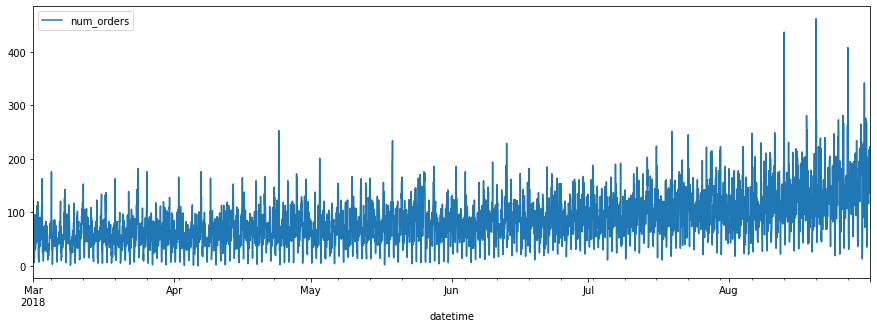

In [17]:
df.plot(figsize=(15,5))

В целом можно заметить что к концу лета количество заказов выросло, думаю пропорционально с этим снизилась температура.

## Анализ

Построим графики сезонности и тренда.

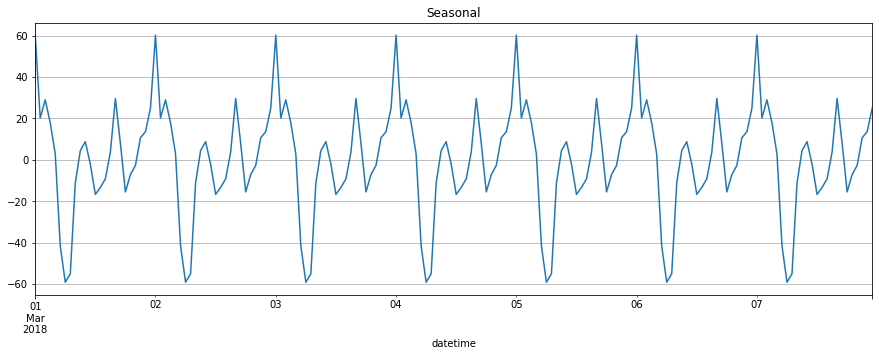

In [18]:
decomposed_df = seasonal_decompose(df)
decomposed_df.seasonal.head(24*7).plot(title='Seasonal', figsize=(15, 5), grid=True);

Мы взяли данные за неделю, из графика видно, что наибольшее количество заказов приходится ближе к полуночи ± 2 часа, а наименьшее - по окончании пикового промежутка и до утра.

<AxesSubplot:title={'center':'Trend'}, xlabel='datetime'>

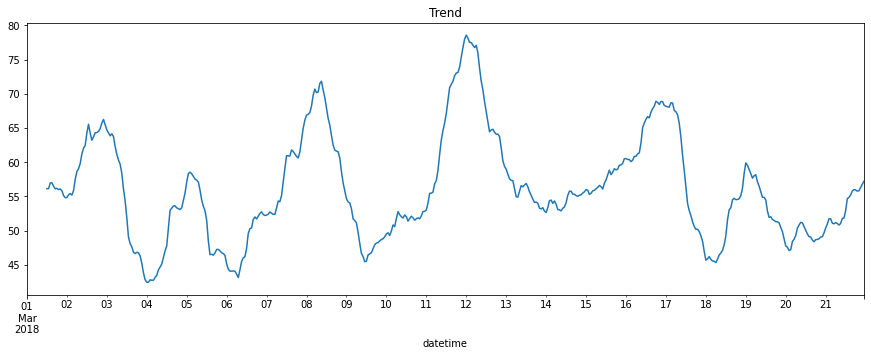

In [19]:
decomposed_df.trend.head(24*21).plot(title='Trend', figsize=(15, 5))

Было решено взять данные за три недели, здесь видно, что по понедельникам такси не так актуально, как по четвергам и пятницам. Это действительно самые востребованные дни недели, ценник на билет у них выше, чем по выходным. Тут все сходится.

<AxesSubplot:xlabel='datetime'>

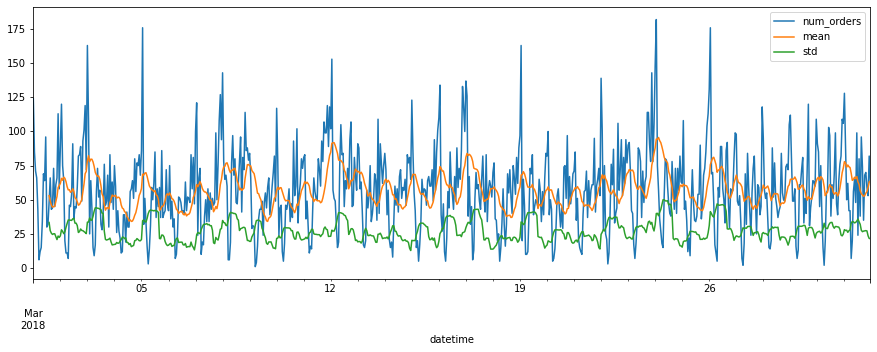

In [20]:
df_for_graph = df['2018-03':'2018-03'].copy()
df_for_graph['mean'] = df_for_graph['num_orders'].rolling(15).mean()
df_for_graph['std'] = df_for_graph['num_orders'].rolling(15).std()
df_for_graph.plot(figsize=(15, 5)) 

График - стационарный, у него не меняется среднее значение и среднее отклонение.

Это хорошо, с такими данными модели будет проще обучаться и предсказывать.

На всякий случай также проверим наш ряд тестом Дики-Фуллера.

In [21]:
ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Наш ряд стационарный


## Обучение

In [22]:
df.isna().mean()

num_orders    0.0
dtype: float64

Создадим функцию с помощью которой добавим в нашу таблицу данные о числе и дне недели. Также добавим столбцы с отстающими значениями и скользящим средним, с помощью которых мы сможем определить растут или уменьшаются значения.

In [23]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 12, 24)

Разобъем данные на обучающую и тестовую выборки. Удалим пропущенные значения для корректной работы и определим признаки.

In [24]:
train, test = train_test_split(df, shuffle=False, test_size=.1)
train = train.dropna()
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

В данном проекте мною было решено воспользоваться гибридными моделями, бытует мнение, что такоевые лучше справляются с задачей временных рядов. 

Итак, проверим.

In [25]:
model = LinearBoostRegressor(base_estimator=LinearRegression(), n_estimators=10, max_depth=3)
model.fit(features_train, target_train)
predict = model.predict(features_train)
rmse = mean_squared_error(target_train, predict) **.5
rmse

23.828088245218638

In [26]:
model = LinearForestRegressor(base_estimator=LinearRegression(), n_estimators=100)
model.fit(features_train, target_train)
predict = model.predict(features_train)
rmse = mean_squared_error(target_train, predict) **.5
rmse

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


8.41855240226837

In [27]:
model = LinearTreeRegressor(base_estimator=LinearRegression(), criterion='rmse', max_depth=5)
model.fit(features_train, target_train)
predict = model.predict(features_train)
rmse = mean_squared_error(target_train, predict) **.5
rmse

21.733073296809966

Лучший результат метрики показал ансамбль линейной регрессии и случайного леса.

## Тестирование

Теперь проверим нашу лучшую модель на тестовой выборке.

In [28]:
model = LinearForestRegressor(base_estimator=LinearRegression(), n_estimators=100)
model.fit(features_train, target_train)
predict = model.predict(features_test)
rmse = mean_squared_error(target_test, predict) **.5
rmse

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


41.90332806632354

Нам это подходит, можно сказать модель справилась. Да здравствует, модель!

## Общий вывод

В этом проекте мы попытались обучить модель предсказывать количество заказов такси в аэропорту.

На входе мы получили данные за почти полгода, построили графики, проанализировали тренды и сезонность. 

Для обучения модели были созданы признаки, из трех моделей была выбрана лучшая - среднее количество ошибок на тестовой выборке составляет 42, что по условию задачи считается приемлимым.